In [51]:
from math import ceil

import cv2
import numpy as np
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_v2_m
from torchvision.transforms import InterpolationMode
import torch.nn.functional as F

import os
import random
from collections import defaultdict

from PIL import Image
from torch.utils import data

from IPython.display import display

In [52]:
TRAIN_PATH = "dataset/train/"
TEST_PATH = "dataset/test"
BATCH_SIZE = 24
LEARNING_RATE = 0.001
MOMENTUM = 0.9
EPOCHS = 150
THRESHOLD = 0.5
INPUT_SIZE = 224

AUG_ROTATION = 5
AUG_TRANSLATE = (0.25, 0.25)
AUG_SCALE = (1, 1)
AUG_GRAYSCALE = 1

In [53]:
class Pair:
	def __init__(self, first, second):
		self.first = first
		self.second = second

	def __repr__(self):
		return str(self)

	def __str__(self) -> str:
		return f"({self.first}, {self.second})"

In [54]:
class TriNet(nn.Module):
	def __init__(self, model):
		super(TriNet, self).__init__()
		self.model = model

	def forward_once(self, x):
		return self.model(x)

	def forward(self, anchor, positive, negative):
		anchor_embedding = self.forward_once(anchor)
		positive_embedding = self.forward_once(positive)
		negative_embedding = self.forward_once(negative)
		return anchor_embedding, positive_embedding, negative_embedding

In [55]:
class TriDataset(data.Dataset):
	def __init__(self, root_dir, transform=None, display=False):
		self.signatures = self.load(root_dir)
		if len(self.signatures) == 1:
			raise Exception()

		self.root_dir = root_dir
		self.transform = transform
		self.display = display

	def __len__(self):
		return len(self.signatures)

	def __getitem__(self, index1):
		(anchor_dir, anchor_list) = self.signatures[index1]

		while True:
			index2 = random.randint(0, len(self.signatures) - 1)
			if index1 != index2:
				(negative_dir, negative_list) = self.signatures[index2]
				break

		def load_img(img_dir, img_name):
			img = Image.open(os.path.join(self.root_dir, img_dir, img_name)).convert("L")
			if self.display:
				display(img)
			return img

		(anchor_entry, positive_entry) = random.sample(anchor_list, 2)
		negative_entry = random.choice(negative_list)

		anchor_entry.first += 1
		positive_entry.first += 1
		negative_entry.first += 1

		anchor_img = load_img(anchor_dir, anchor_entry.second)
		positive_img = load_img(anchor_dir, positive_entry.second)
		negative_img = load_img(negative_dir, negative_entry.second)

		if self.transform:
			anchor_img = self.transform(anchor_img)
			positive_img = self.transform(positive_img)
			negative_img = self.transform(negative_img)

		return anchor_img, positive_img, negative_img

	@staticmethod
	def load(root_dir):
		dataset = defaultdict(list)

		for dir_name in os.listdir(root_dir):
			dir_path = os.path.join(root_dir, dir_name)
			if not os.path.isdir(dir_path):
				continue

			for file_name in os.listdir(dir_path):
				file_path = os.path.join(dir_path, file_name)
				if not os.path.isfile(file_path):
					continue

				dataset[dir_name].append(Pair(0, file_name))

		return list(dataset.items())


In [56]:
def adaptive_threshold(image):
	image = np.array(image)
	image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 12)
	image = Image.fromarray(image)
	return image

In [57]:
AUGMENTATION = transforms.Compose([
	# transforms.RandomGrayscale(p=AUG_GRAYSCALE),
	transforms.RandomAffine(
		degrees=AUG_ROTATION,
		translate=AUG_TRANSLATE,
		scale=AUG_SCALE,
		interpolation=InterpolationMode.BILINEAR,
		fill=255
	)
])

TRANSFORM = transforms.Compose([
	transforms.Resize((INPUT_SIZE, INPUT_SIZE)),  # Resize the image to the desired input size
	adaptive_threshold,
	transforms.ToTensor(),  # Convert the image to a tensor
	# transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
	transforms.Normalize(mean=[0.485], std=[0.229])
])

TRAIN_TRANSFORM = transforms.Compose([
	AUGMENTATION,
	TRANSFORM
])

In [58]:
def train(device, batch_size=BATCH_SIZE, epochs=EPOCHS, optimizer=None):
	dataset = TriDataset(TRAIN_PATH, transform=TRAIN_TRANSFORM)

	architecture = efficientnet_v2_m()
	architecture.features[0][0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
	model = TriNet(architecture)

	loss_fn = nn.TripletMarginWithDistanceLoss(
		distance_function=lambda x, y: (1.0 - F.cosine_similarity(x, y))
	)

	data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

	if optimizer is None:
		optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

	model.to(device)
	display(model)

	iter_count = ceil(len(dataset) / batch_size)

	for epoch in range(epochs):
		model.train()
		i = 0
		running_loss = 0

		for batch_idx, (anchor, positive, negative) in enumerate(data_loader):
			optimizer.zero_grad()

			anchor = anchor.to(device)
			positive = positive.to(device)
			negative = negative.to(device)

			(anchor, positive, negative) = model(anchor, positive, negative)
			loss = loss_fn(anchor, positive, negative)

			loss.backward()
			optimizer.step()

			if i < iter_count:
				print('\r', end='')

			i += 1
			loss_item = loss.item()

			print(f"Epoch: {epoch + 1}/{epochs}, Iter: {i}/{iter_count}, Loss: {loss_item}", end='')

			running_loss += loss_item
			if i == iter_count:
				print(f"\nAvg: {running_loss / iter_count}")
				running_loss = 0

		if (epoch + 1) % 100 == 0:
			torch.save(model, f"model_{epoch + 1}.pt")
	return model

In [61]:
def test(model, device, dataset):
	data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
	model.eval()
	with torch.no_grad():
		for batch_idx, (anchor, positive, negative) in enumerate(data_loader):
			anchor = anchor.to(device)
			positive = positive.to(device)
			negative = negative.to(device)
			anchor, positive, negative = model(anchor, positive, negative)

			pos = (1 - nn.functional.cosine_similarity(anchor, positive)) / 2
			neg = (1 - nn.functional.cosine_similarity(anchor, negative)) / 2
			pos_neg = (1 - nn.functional.cosine_similarity(positive, negative)) / 2

			print(
				f"Pos: {pos.item()}, Neg: {neg.item()}, PosNeg: {pos_neg.item()}")


In [59]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
MODEL = train(DEVICE)
torch.save(MODEL, "model.pt")

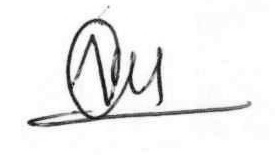

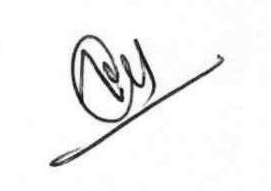

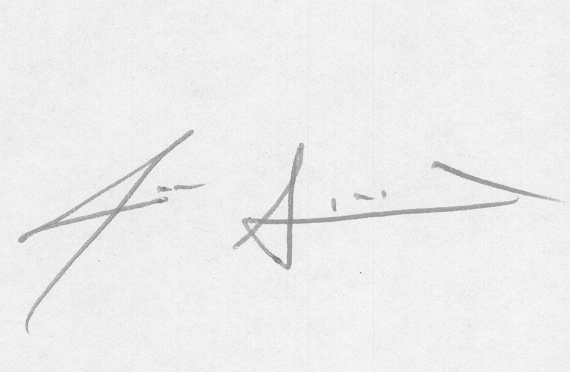

Pos: 0.07037055492401123, Neg: 0.7708856463432312, PosNeg: 0.7076297998428345


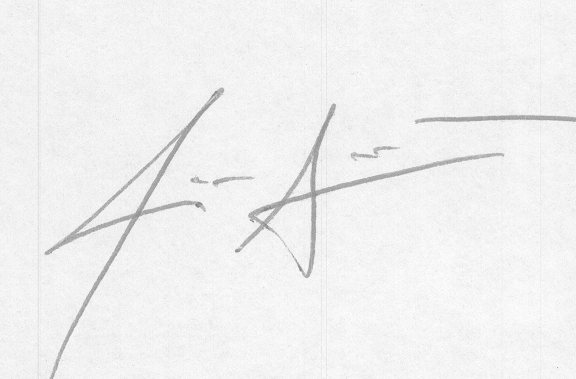

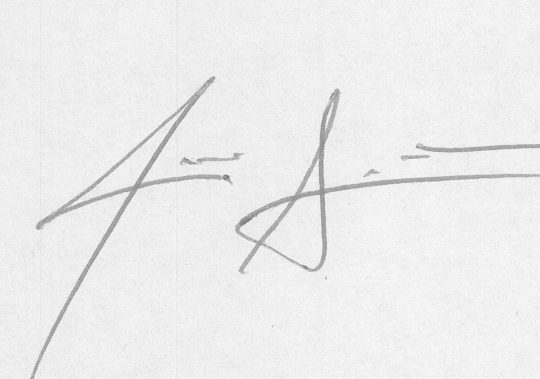

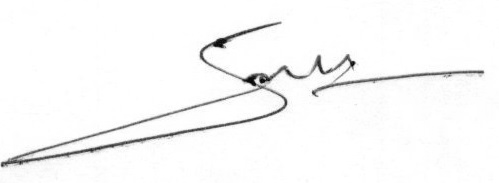

Pos: 0.006460458040237427, Neg: 0.1639980673789978, PosNeg: 0.1283734142780304


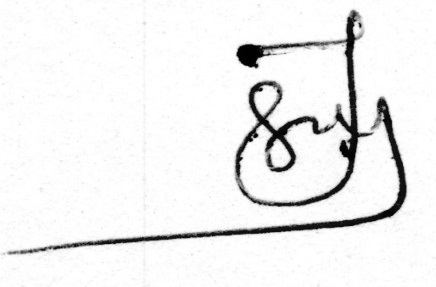

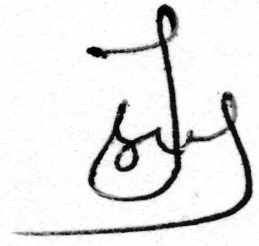

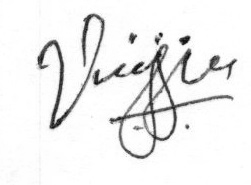

Pos: 0.04136788845062256, Neg: 0.6061257719993591, PosNeg: 0.7233729958534241


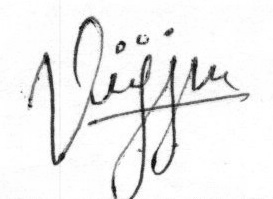

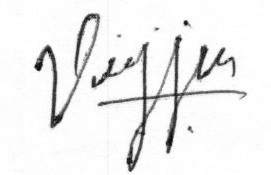

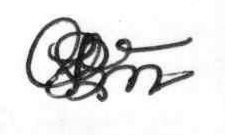

Pos: 0.04098331928253174, Neg: 0.6637246012687683, PosNeg: 0.7453805208206177


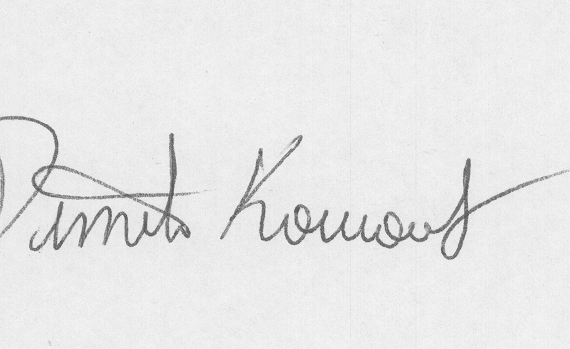

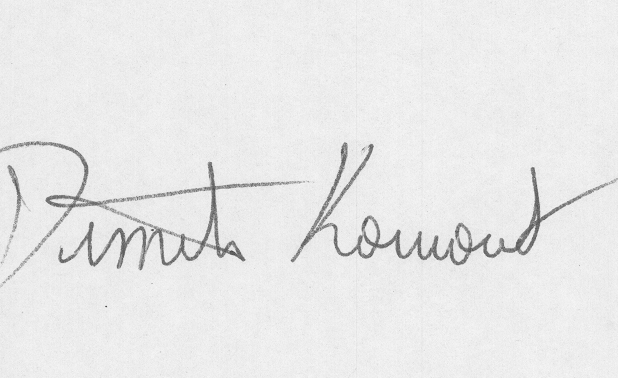

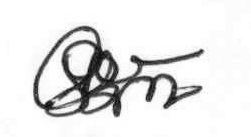

Pos: 0.0006097853183746338, Neg: 0.5127785205841064, PosNeg: 0.5055367946624756


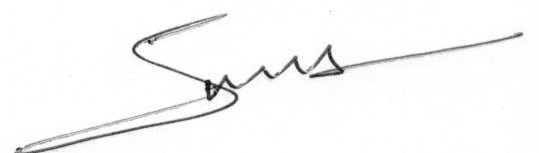

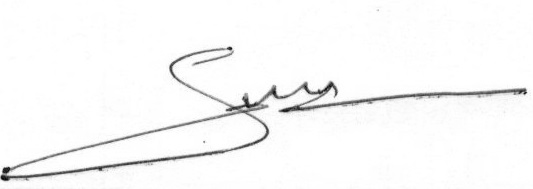

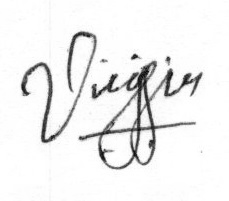

Pos: 0.005242645740509033, Neg: 0.5629668235778809, PosNeg: 0.5450627207756042


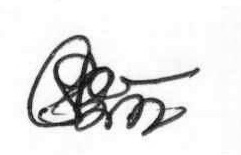

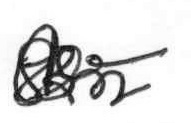

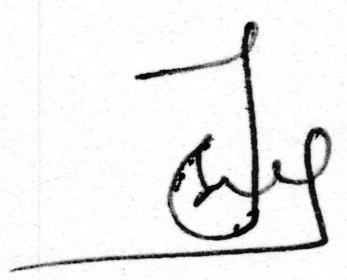

Pos: 0.009009718894958496, Neg: 0.19261887669563293, PosNeg: 0.24743014574050903


In [62]:
MODEL = torch.load("weights/model.pt")
TEST_DATASET = TriDataset(TEST_PATH, transform=TRANSFORM, display=True)
test(MODEL, DEVICE, TEST_DATASET)

In [63]:
print("Hello, World!")

Hello, World!
